In [81]:
import torch   #科学计算框架
import torchvision  #处理图像视频 
import torchvision.transforms as transforms  #处理图形变换

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),   #ToTensor()能够把灰度范围从0-255变换到0-1之间
     transforms.Normalize((0.5), (0.5))])  #把0-1变换到(-1,1).

input_size=28*28
output_size=10

batch_size=64   #单次传递给程序用以训练的参数个数
trainset = torchvision.datasets.MNIST(root='./data', train=True,    #训练集
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,   #
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,     #测试集
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

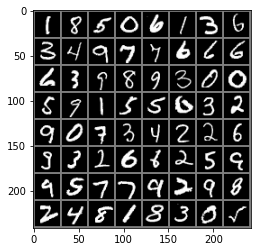

1     8     5     0     6     1     3     6     3     4     9     7     7     6     6     6     6     3     9     8     9     3     0     0     5     9     1     5     5     0     3     2     9     0     7     3     4     2     2     6     9     3     2     6     6     2     5     9     9     5     7     7     9     2     9     8     2     4     8     1     8     3     0     5    


In [82]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)   #采用iter(dataloader)返回的是一个迭代器
images, labels = dataiter.next()   #使用next()访问

# show images
imshow(torchvision.utils.make_grid(images))   #拼接图片
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [83]:
import torch.nn as nn
import torch.nn.functional as F

#卷积神经网络
class Net(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  #卷积层：提取图像中的局部特征
        self.pool = nn.MaxPool2d(2, 2)    #池化层：大幅降低参数量级(降维)
        self.conv2 = nn.Conv2d(6, 16, 5)   
        self.fc1 = nn.Linear(16 * 4* 4, 64)  #全连接层：不断训练，最后输出一个二分类数值
        self.fc2 = nn.Linear(64, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):   #。forward接受一个input，返回一个网络输出值
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))   #激活函数：把所有的非零值转化成零值
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [84]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  #损失函数初始化
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  #SGD 优化器  net.parameters()：训练参数

In [85]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs,lables=inputs.to(device),labels.to(device)
        inputs, labels = data
       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [86]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)  #保存模型等相关参数

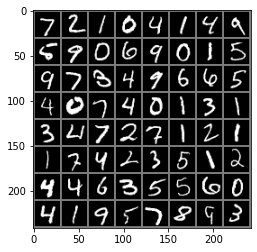

GroundTruth:  7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3    


In [87]:
dataiter = iter(testloader)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

In [88]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():  #强制之后的内容不进行计算图构建
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %


In [89]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.1 %
Accuracy for class: 1     is 99.6 %
Accuracy for class: 2     is 96.9 %
Accuracy for class: 3     is 94.0 %
Accuracy for class: 4     is 96.3 %
Accuracy for class: 5     is 98.7 %
Accuracy for class: 6     is 96.1 %
Accuracy for class: 7     is 97.0 %
Accuracy for class: 8     is 94.3 %
Accuracy for class: 9     is 95.4 %
